Before 34660
After 34627
train length: 27701
train split: 5.0    0.686112
4.0    0.246598
3.0    0.043717
2.0    0.011696
1.0    0.010866
Name: reviews.rating, dtype: float64
test length: 6926
Test split: 5.0    0.686110
4.0    0.246463
3.0    0.041294
1.0    0.014294
2.0    0.011118
Name: reviews.rating, dtype: float64


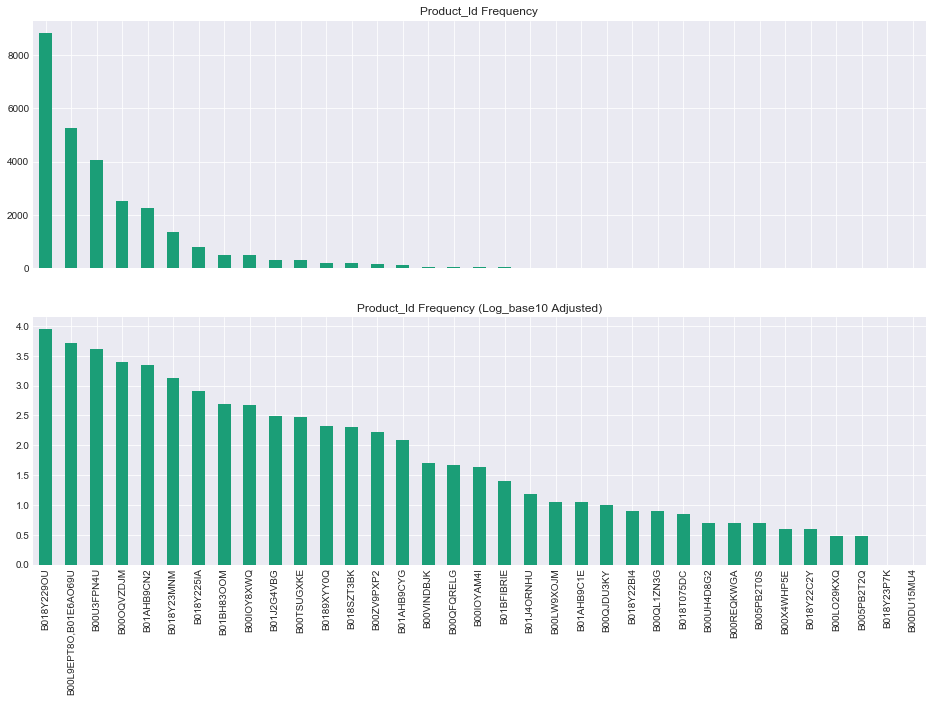

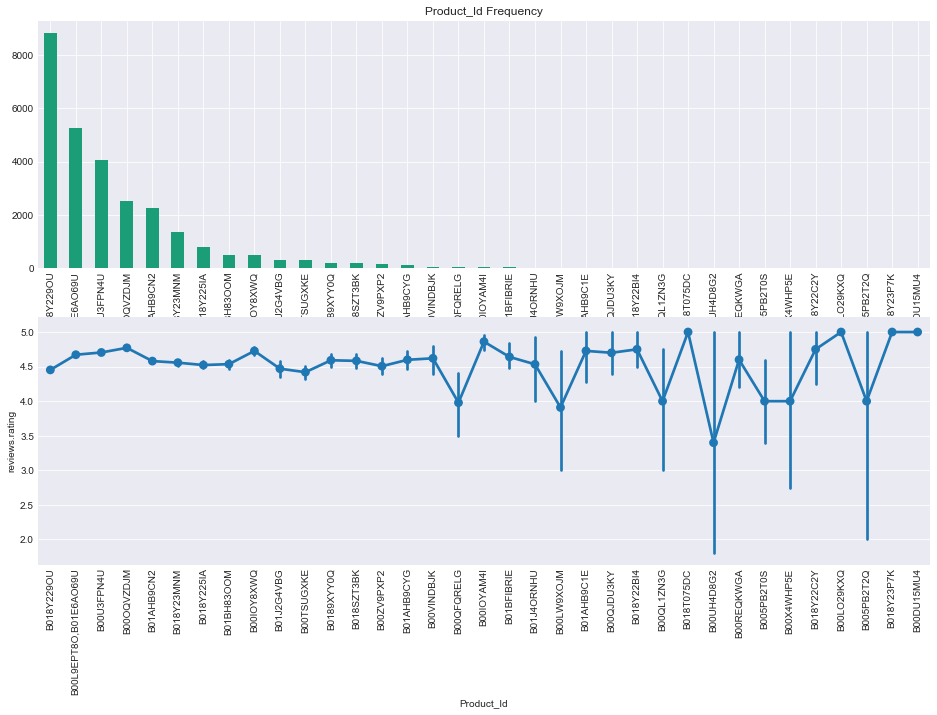

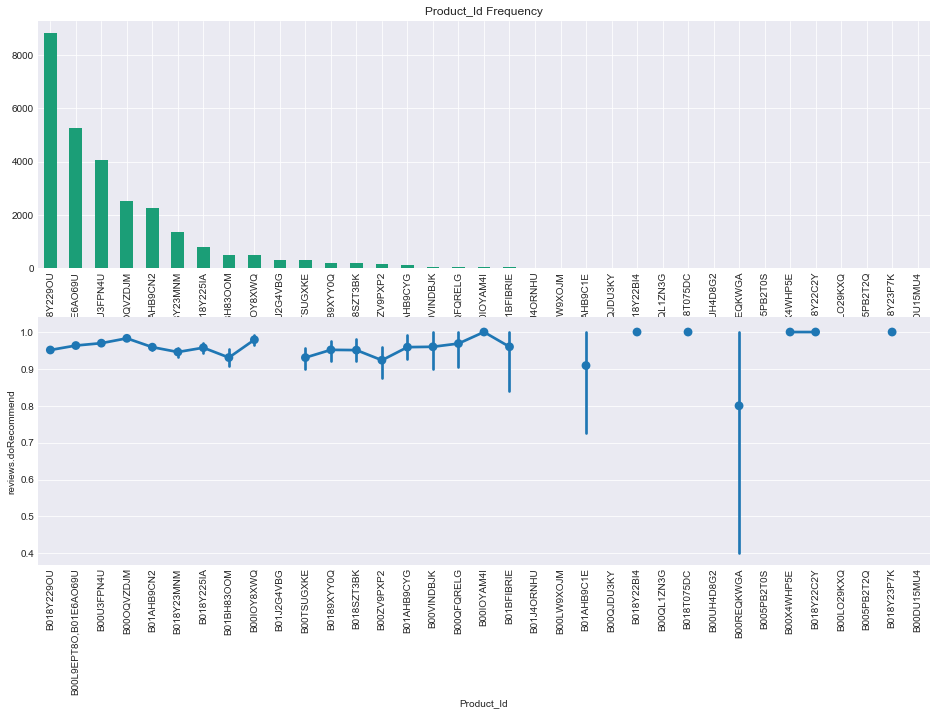

                      reviews.id  reviews.numHelpful  reviews.rating  \
reviews.id                   NaN                 NaN             NaN   
reviews.numHelpful           NaN            1.000000       -0.027287   
reviews.rating               NaN           -0.027287        1.000000   
reviews.userCity             NaN                 NaN             NaN   
reviews.userProvince         NaN                 NaN             NaN   

                      reviews.userCity  reviews.userProvince  
reviews.id                         NaN                   NaN  
reviews.numHelpful                 NaN                   NaN  
reviews.rating                     NaN                   NaN  
reviews.userCity                   NaN                   NaN  
reviews.userProvince               NaN                   NaN  
27701 6926


(27701, 12540)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore') 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("darkgrid") 
get_ipython().run_line_magic('matplotlib', 'inline')
np.random.seed(4945) 

csv = "BP_4945.csv"
df = pd.read_csv(csv)
tabl = df.copy()

from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(tabl)))
tablAfter = tabl.dropna(subset=["reviews.rating"]) # removing NAN
print("After {}".format(len(tablAfter)))
tablAfter["reviews.rating"] = tablAfter["reviews.rating"].astype(int)


split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(tablAfter, tablAfter["reviews.rating"]): 
    sentiment_train = tablAfter.reindex(train_index)
    sentiment_test = tablAfter.reindex(test_index)

print("train length:", len(sentiment_train))

print("train split:", sentiment_train["reviews.rating"].value_counts()/len(sentiment_train)) # value_count() counts all the values based on column


print("test length:",len(sentiment_test))


print("Test split:", sentiment_test["reviews.rating"].value_counts()/len(sentiment_test))
reviews = sentiment_train.copy()

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
reviews["Product_Id"].value_counts().plot(kind="bar", ax=ax1, title="Product_Id Frequency",cmap = 'Dark2')
np.log10(reviews["Product_Id"].value_counts()).plot(kind="bar", ax=ax2, title="Product_Id Frequency (Log_base10 Adjusted)",cmap = 'Dark2') 
plt.show()


Product_Id_count_ix = reviews["Product_Id"].value_counts().index
plt.subplots(2,1,figsize=(16,10))
plt.subplot(2,1,1)
reviews["Product_Id"].value_counts().plot(kind="bar", title="Product_Id Frequency",cmap = 'Dark2')
plt.subplot(2,1,2)
sns.pointplot(x="Product_Id", y="reviews.rating", order=Product_Id_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

plt.subplots (2,1,figsize=(16,10))
plt.subplot(2,1,1)
reviews["Product_Id"].value_counts().plot(kind="bar", title="Product_Id Frequency",cmap = 'Dark2')
plt.subplot(2,1,2)
sns.pointplot(x="Product_Id", y="reviews.doRecommend", order=Product_Id_count_ix, data =reviews)
plt.xticks(rotation=90)
plt.show()

corr_matrix = reviews.corr()
print(corr_matrix)

counts = reviews["Product_Id"].value_counts().to_frame()


avg_rating = reviews.groupby("Product_Id")["reviews.rating"].mean().to_frame()
avg_rating.head()


table = counts.join(avg_rating)

def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
sentiment_train["Sentiment"] = sentiment_train["reviews.rating"].apply(sentiments)
sentiment_test["Sentiment"] = sentiment_test["reviews.rating"].apply(sentiments)
sentiment_train["Sentiment"][:20]

# Prepare data
train_x = sentiment_train["reviews.text"]
train_x_target_sent = sentiment_train["Sentiment"]
test_x = sentiment_test["reviews.text"]
test_x_target_sent = sentiment_test["Sentiment"]
print(len(train_x), len(test_x))

# Replace "nan" with space
train_x = train_x.fillna(' ')
test_x = test_x.fillna(' ')
train_x_target_sent = train_x_target_sent.fillna(' ')
test_x_target_sent = test_x_target_sent.fillna(' ')

# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vec = CountVectorizer()
train_x_counts = count_vec.fit_transform(train_x) 
train_x_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
train_x_tfidf = tfidf_transformer.fit_transform(train_x_counts)
train_x_tfidf.shape



In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
NB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
NB_pipe.fit(train_x, train_x_target_sent)

import numpy as np
predicted_NB = NB_pipe.predict(test_x)
print("Naive Bayes Test Data Performance :",np.mean(predicted_NB == test_x_target_sent))


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
log_reg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
log_reg_pipe.fit(train_x, train_x_target_sent)

import numpy as np
predictedLogReg = log_reg_pipe.predict(test_x)
print("Logistic Regression Test Data Performance :",np.mean(predictedLogReg == test_x_target_sent))


from sklearn.tree import DecisionTreeClassifier
DT_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())])
DT_pipe.fit(train_x, train_x_target_sent)

predictedDecisionTree = DT_pipe.predict(test_x)
print("Decision Tree Test Data Performance :",np.mean(predictedDecisionTree == test_x_target_sent))


from sklearn.ensemble import RandomForestClassifier
RF_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randomForest", RandomForestClassifier())])
RF_pipe.fit(train_x, train_x_target_sent)

predictedRandomForest = RF_pipe.predict(test_x)
print("Random Forest Test Data Performance :", np.mean(predictedRandomForest == test_x_target_sent))

Naive Bayes Test Data Performance : 0.9325729136586774
Logistic Regression Test Data Performance : 0.9369044181345654
Decision Tree Test Data Performance : 0.8986427952642217
Random Forest Test Data Performance : 0.9332948310713255


In [3]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(train_x, train_x_target_sent)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(test_x)
print("Logistic Regression Test Data Performance with best param on grid :",np.mean(predictions == test_x_target_sent))

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(test_x_target_sent,predictions ))
print('Accuracy: {}'. format(accuracy_score(test_x_target_sent, predictions)))

from sklearn import metrics
metrics.confusion_matrix(test_x_target_sent, predictions)

The best paramenter set is : 
 {'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__min_df': 3, 'lr__C': 10}
Logistic Regression Test Data Performance with best param on grid : 0.9396477043026278
             precision    recall  f1-score   support

                  0.00      0.00      0.00         5
   Negative       0.69      0.26      0.37       176
    Neutral       0.46      0.14      0.21       286
   Positive       0.95      0.99      0.97      6459

avg / total       0.92      0.94      0.92      6926

Accuracy: 0.9396477043026278


array([[   0,    0,    0,    5],
       [   0,   45,   18,  113],
       [   0,   13,   39,  234],
       [   0,    7,   28, 6424]], dtype=int64)